In [1]:
from detprocess import Noise
from detprocess import Template
import qetpy as qp
from qetpy.utils import shift
from pytesdaq.io.hdf5 import H5Reader

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 6.5]

import numpy as np
import pandas as pd
from pprint import pprint
import astropy
import vaex as vx
from detanalysis import Analyzer


import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 96 from PyObject


In [2]:
#Make sure you have 
# Noise_csd, some Noise traces and their metadata, also you have some signal traces and their metadata 
!ls

Noise_csd.npy		   OF_NxM_demo.ipynb	       Signal_traces.npy
Noise_traces_metadata.npy  OF_NxMx2_demo.ipynb
Noise_traces.npy	   Signal_traces_metadata.npy


INFO: Creating 3-poles template (tag="default")
INFO: Creating 3-poles template (tag="default")
INFO: Creating 3-poles template (tag="default")


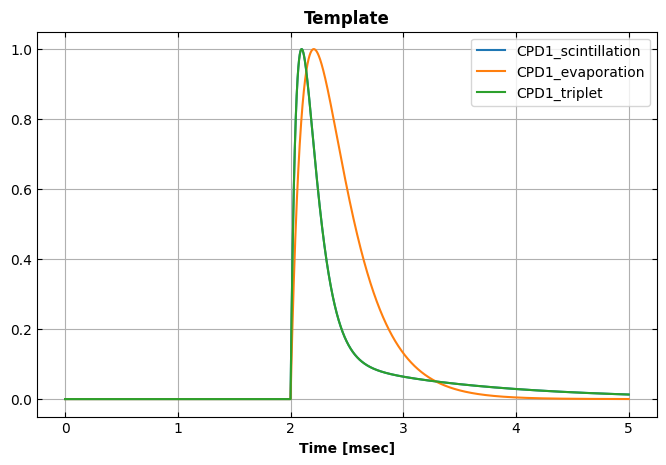

In [3]:
# next goal is to make template, I have average out a alot of signal form CPDs and made these templates 

template_gen = Template(verbose=True)


template_gen.create_template('CPD1_scintillation',A= 0.1293, B= 8.327, 
                         	trace_length_msec=5, #msec
                         	pretrigger_length_msec=2, #msec
                         	sample_rate=1.25e6,
                         	tau_r=82.37e-6, #sec
                         	tau_f1=1.268e-3, #sec
                        	tau_f2=108.81e-6) #sec


template_gen.create_template('CPD1_evaporation',A= 1.350 , B= 0.766,  
                         	trace_length_msec=5, #msec
                         	pretrigger_length_msec=2, #msec
                         	sample_rate=1.25e6,
                         	tau_r=163.2e-6, #sec
                         	tau_f1=177.0e-6, #sec
                        	tau_f2=299.3e-6) #sec


template_gen.create_template('CPD1_triplet',A= 0.1293, B= 8.327, 
                         	trace_length_msec=5, #msec
                         	pretrigger_length_msec=2, #msec
                         	sample_rate=1.25e6,
                         	tau_r=82.37e-6, #sec
                         	tau_f1=1.268e-3, #sec
                        	tau_f2=108.81e-6) #sec


template_gen.plot_template(['CPD1_scintillation','CPD1_evaporation','CPD1_triplet'])

INFO: Creating 3-poles template (tag="default")
INFO: Creating 3-poles template (tag="default")
INFO: Creating 3-poles template (tag="default")


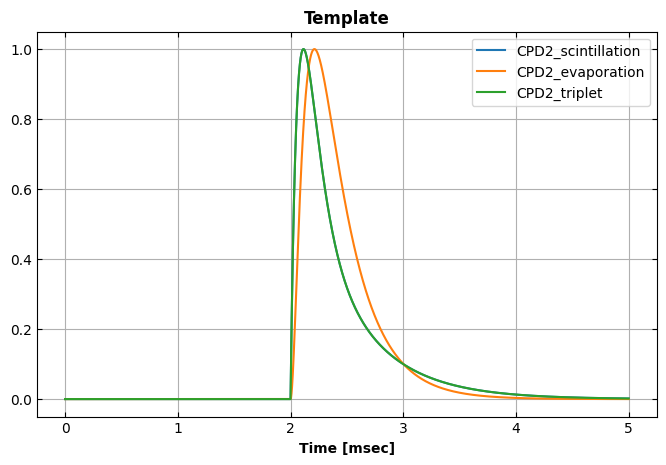

In [4]:
## here I have used same scintillation pulse as in dry case and a three pole pulse for evaporation


template_gen.create_template('CPD2_scintillation',A= 0.553, B= 11.1, 
                         	trace_length_msec=5, #msec
                         	pretrigger_length_msec=2, #msec
                         	sample_rate=1.25e6,
                         	tau_r=0.0895e-3, #sec
                         	tau_f1=0.489e-3, #sec
                        	tau_f2=0.0998e-3) #sec




template_gen.create_template('CPD2_evaporation',A= 1.350 , B= 0.766,  
                         	trace_length_msec=5, #msec
                         	pretrigger_length_msec=2, #msec
                         	sample_rate=1.25e6,
                         	tau_r=94.2e-6, #sec
                         	tau_f1=291.8e-6, #sec
                        	tau_f2=43.10e-6) #sec


template_gen.create_template('CPD2_triplet',A= 0.553, B= 11.1, 
                         	trace_length_msec=5, #msec
                         	pretrigger_length_msec=2, #msec
                         	sample_rate=1.25e6,
                         	tau_r=0.0895e-3, #sec
                         	tau_f1=0.489e-3, #sec
                        	tau_f2=0.0998e-3) #sec


template_gen.plot_template(['CPD2_scintillation','CPD2_evaporation','CPD2_triplet'])

In [5]:
#lets put the template into a numpy arary for easy of handling
CPD1_scintillation, t = template_gen.get_template('CPD1_scintillation')
CPD1_evaporation, t = template_gen.get_template('CPD1_evaporation')
CPD1_triplet, t = template_gen.get_template('CPD1_triplet')

CPD2_scintillation, t = template_gen.get_template('CPD2_scintillation')
CPD2_evaporation, t = template_gen.get_template('CPD2_evaporation')
CPD2_triplet, t = template_gen.get_template('CPD2_triplet')

In [6]:
#one can either load the noise_csd directly into the nxmx2 or you can actually generate the corelated and uncorelated noise yourself: 
#for that you have to load the noise traces 
traces = np.load("Noise_traces.npy")
traces_metadata = np.load("Noise_traces_metadata.npy",allow_pickle=True)
Noise = qp.Noise(traces, traces_metadata.item()['sample_rate'], ['CPD1','CPD2'])
Noise.calculate_psd()
Noise.calculate_csd(twosided=True)
freqs=np.fft.fftfreq(len(Noise.csd[-2,-2,:]),d=1/traces_metadata.item()['sample_rate'])
Noise.calculate_uncorr_noise()

(0.1, 10000.0)

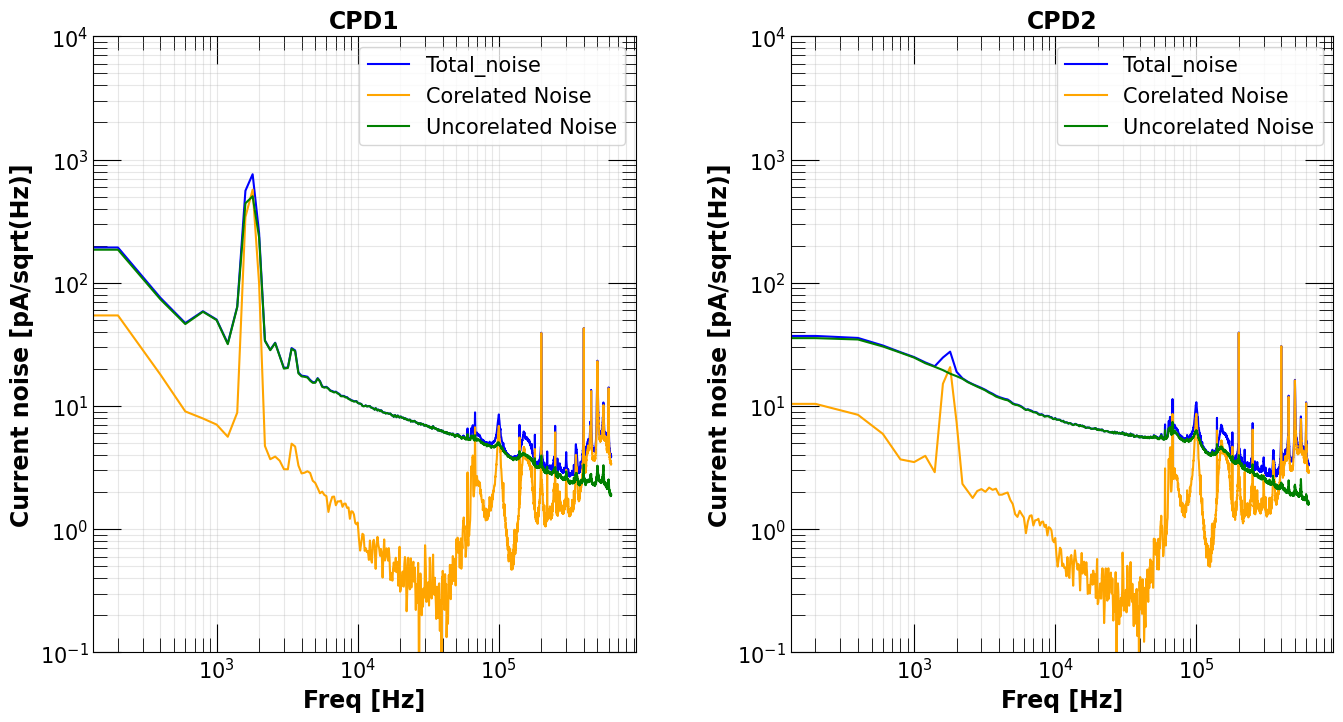

In [7]:
# lets plot it the np.srt(csd)...csd is in A^2/Hz 

f_cutoff= int(len(Noise.csd_freqs)/2)



fig = plt.figure(1,figsize=(16,8))
gs=GridSpec(4,4)
gs.update(wspace=0.8,hspace=0.5)
t=np.arange(-2,3,1/1250)# ms 
##first plot#####
xtr_subplot =fig.add_subplot(gs[0:4,0:2])

plt.plot(Noise.csd_freqs[:f_cutoff], np.sqrt(Noise.csd[0,0,:f_cutoff])*1e12,color = 'blue', label = "Total_noise" )

plt.plot(Noise.csd_freqs[:f_cutoff], np.sqrt(Noise.corrnoise[0][:f_cutoff])*1e12,  color ='orange', label = "Corelated Noise")

plt.plot(Noise.csd_freqs[:f_cutoff], np.sqrt(Noise.uncorrnoise[0][:f_cutoff])*1e12,  color = 'green',label = "Uncorelated Noise")


plt.xscale("log")
plt.yscale("log")

plt.ylabel(r'Current noise [pA/sqrt(Hz)]',fontsize=17,fontweight='bold')
plt.xlabel(r'Freq [Hz]',fontsize=17,fontweight='bold')
plt.title(r'CPD1',fontsize=17,fontweight='bold')
plt.tick_params(direction='in',which='minor',length=10,bottom=True, top =True, left=True, right=True)
plt.tick_params(direction='in',which='major',length=20,bottom=True, top =True, left=True, right=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.title("Scintillation",fontsize=17,fontweight='bold')
plt.grid(which ='both', alpha =0.3)

plt.legend(fontsize=15)
plt.ylim(1e-1,1e4)


##second plot#####
xtr_subplot =fig.add_subplot(gs[0:4,2:4])

plt.plot(Noise.csd_freqs[:f_cutoff], np.sqrt(Noise.csd[1,1,:f_cutoff])*1e12,color = 'blue', label = "Total_noise")

plt.plot(Noise.csd_freqs[:f_cutoff], np.sqrt(Noise.corrnoise[1][:f_cutoff])*1e12,  color ='orange', label = "Corelated Noise")
plt.plot(Noise.csd_freqs[:f_cutoff], np.sqrt(Noise.uncorrnoise[1][:f_cutoff])*1e12,  color = 'green',label = "Uncorelated Noise")



plt.xscale("log")
plt.yscale("log")


plt.ylabel(r'Current noise [pA/sqrt(Hz)]',fontsize=17,fontweight='bold')
plt.xlabel(r'Freq [Hz]',fontsize=17,fontweight='bold')
plt.title(r'CPD2',fontsize=17,fontweight='bold')
plt.tick_params(direction='in',which='minor',length=10,bottom=True, top =True, left=True, right=True)
plt.tick_params(direction='in',which='major',length=20,bottom=True, top =True, left=True, right=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.title("Scintillation",fontsize=17,fontweight='bold')
plt.grid(which ='both', alpha =0.3)

plt.legend(fontsize=15)

plt.ylim(1e-1,1e4)

#plt.plot(Noise.csd_freqs[:f_cutoff], np.sqrt(Noise.csd[0,0,:f_cutoff])*1e12, label = "PSD CPD1 or J11")


In [8]:
#lets load in some signal traces 
signal_traces = np.load("Signal_traces.npy")
signal_traces_metadata = np.load("Signal_traces_metadata.npy",allow_pickle=True)

In [21]:
#for some reson the traces file are too big, so I am unable to upload it
noise_csd = np.load("Noise_csd.npy")

In [22]:
# you we have everything ready to start calling OF_nxmx2

#First what is the channel list, you have to define it this way : ( 
channel_name_list="CPD1|CPD2"

#First lets define what are the different types of template you want to have: m different types, they can different among the channels
template_tags_2x4 = ['scintillation_CPD1','evaporation_CPD1','scintillation_CPD2','evaporation_CPD2']


# I will use a OF_2x2 also  
template_tags_2x2 = ['CPD1_scintillation', 'CPD2_scintillation']

# m different types of templates for each channel: a total of 8 different templates 
#I want to extarct out only the scintillation part of teh signal thus  have made all zeros
template_array_2x4 = np.asarray((CPD1_scintillation, 0*CPD1_evaporation, 0*CPD2_scintillation, 0*CPD2_evaporation,\
                                 0*CPD1_scintillation, 0*CPD1_evaporation, CPD2_scintillation, 0*CPD2_evaporation))

# I will use a OF_2x2 also  
template_array_2x2 = np.asarray((CPD1_scintillation, 0*CPD2_scintillation,\
                                 0*CPD1_scintillation, CPD2_scintillation))


#csd = np.copy(Noise.csd)
csd = np.copy(noise_csd)

#a noise trace is needed for the nxm function
noise_traces= traces[0]

#smapling frequency 
fs = traces_metadata.item()['sample_rate']

In [23]:
#We will use this function to instantiate the OF NxM
def Call_NxM_optimal_Filter_object(template_array, template_tags, csd, noise_traces, channel_name_list, fs, pretrigger_samples):
    # instantiate OFnxm
    return qp.OFnxm(of_base=None, templates =template_array, template_tags=template_tags , channels= channel_name_list, 
                    csd=csd, noise_traces=noise_traces, sample_rate=fs, pretrigger_samples=pretrigger_samples)

In [24]:
#lets define 2x4 first
OF_2x4 = Call_NxM_optimal_Filter_object(template_array_2x4,template_tags_2x4, csd,noise_traces, channel_name_list, fs, 2500)

INFO: Adding template with tag scintillation_CPD1 to OF base object. Channel isCPD1
***********
CPD1 scintillation_CPD1
[ 481.39788491  -0.j         -372.13176521 -50.57309156j
  254.84461771+190.78859028j ... -136.29573801+247.85999549j
  254.84461771-190.78859028j -372.13176521 +50.57309156j]
6250 200.0
***********
INFO: Adding template with tag evaporation_CPD1 to OF base object. Channel isCPD1
***********
CPD1 evaporation_CPD1
[nan -0.j nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
6250 200.0
***********
INFO: Adding template with tag scintillation_CPD2 to OF base object. Channel isCPD1
***********
CPD1 scintillation_CPD2
[nan -0.j nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
6250 200.0
***********
INFO: Adding template with tag evaporation_CPD2 to OF base object. Channel isCPD1
***********
CPD1 evaporation_CPD2
[nan -0.j nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
6250 200.0
***********
INFO: Adding template with tag scintillation_CPD1 to OF base object. Channel isC

In [25]:
#than define 2x2 
OF_2x2 = Call_NxM_optimal_Filter_object(template_array_2x2,template_tags_2x2, csd,noise_traces, channel_name_list, fs, 2500)

INFO: Adding template with tag CPD1_scintillation to OF base object. Channel isCPD1
***********
CPD1 CPD1_scintillation
[ 481.39788491  -0.j         -372.13176521 -50.57309156j
  254.84461771+190.78859028j ... -136.29573801+247.85999549j
  254.84461771-190.78859028j -372.13176521 +50.57309156j]
6250 200.0
***********
INFO: Adding template with tag CPD2_scintillation to OF base object. Channel isCPD1
***********
CPD1 CPD2_scintillation
[nan -0.j nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
6250 200.0
***********
INFO: Adding template with tag CPD1_scintillation to OF base object. Channel isCPD2
***********
CPD2 CPD1_scintillation
[nan -0.j nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
6250 200.0
***********
INFO: Adding template with tag CPD2_scintillation to OF base object. Channel isCPD2
***********
CPD2 CPD2_scintillation
[ 581.33658429  -0.j         -506.4539598  -63.00726313j
  365.65243076+168.70149176j ... -217.42435174+244.65491452j
  365.65243076-168.70149176j -506.453

In [13]:
#First fit with 2x2 and than with 2x4 ....rememeber we have added reduntant degrees of freedom 

i=36
OF_2x4.calc(channels= channel_name_list, signal=signal_traces[i])
OF_2x4.get_fit_withdelay(channels= channel_name_list, signal=signal_traces[i])



(array([8.01198586e-08, 0.00000000e+00, 1.59476535e-07, 0.00000000e+00]),
 2.4e-06,
 18724.336211212365)

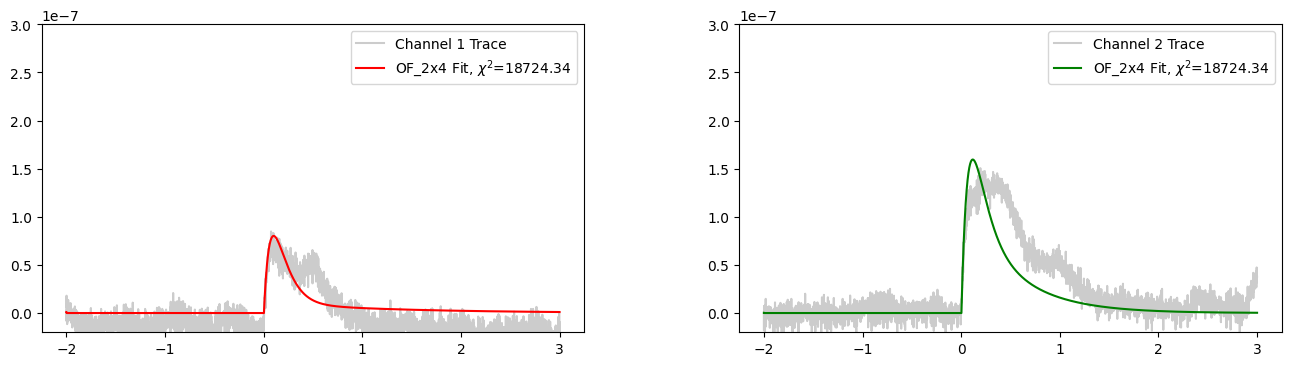

In [15]:
t=np.arange(-2,3,1/(1250))

fig = plt.figure(1,figsize=(16,4))
gs=GridSpec(4,4)
gs.update(wspace=0.8,hspace=0.5)
t=np.arange(-2,3,1/1250)# ms 
##first plot#####
xtr_subplot =fig.add_subplot(gs[0:4,0:2])

template_array_2x4 = np.asarray((CPD1_scintillation, CPD1_evaporation, 0*CPD2_scintillation, 0*CPD2_evaporation,\
                              0*CPD1_scintillation, 0*CPD1_evaporation, CPD2_scintillation, CPD2_evaporation))

template_11 = template_array_2x4[0]
template_21 = template_array_2x4[1]
template_31 = template_array_2x4[2]
template_41 = template_array_2x4[3]

Fit_channel_1 =  OF_2x4._of_amp_withdelay[0]*np.roll(template_11,int(OF_2x4._of_t0_withdelay*OF_2x4._fs)) + \
OF_2x4._of_amp_withdelay[1]*np.roll(template_21,int(OF_2x4._of_t0_withdelay*OF_2x4._fs)) +\
OF_2x4._of_amp_withdelay[2]*np.roll(template_31,int(OF_2x4._of_t0_withdelay*OF_2x4._fs)) + OF_2x4._of_amp_withdelay[3]*np.roll(template_41,int(OF_2x4._of_t0_withdelay*OF_2x4._fs))

plt.plot(t,signal_traces[i][0], color='k', alpha=0.2,label= "Channel 1 Trace")
plt.plot(t, Fit_channel_1 , color='red', label=(r'OF_2x4 Fit, $\chi^2$'+ f'={OF_2x4._of_chi2_withdelay:.2f}'))
plt.ylim(-0.2e-7,3e-7)
plt.legend()
##first plot#####
xtr_subplot =fig.add_subplot(gs[0:4,2:4])


template_12 = template_array_2x4[4]
template_22 = template_array_2x4[5]
template_32 = template_array_2x4[6]
template_42 = template_array_2x4[7]

Fit_channel_2 =  OF_2x4._of_amp_withdelay[0]*np.roll(template_12,int(OF_2x4._of_t0_withdelay*OF_2x4._fs)) +\
OF_2x4._of_amp_withdelay[1]*np.roll(template_22,int(OF_2x4._of_t0_withdelay*OF_2x4._fs)) +\
OF_2x4._of_amp_withdelay[2]*np.roll(template_32,int(OF_2x4._of_t0_withdelay*OF_2x4._fs))+OF_2x4._of_amp_withdelay[3]*np.roll(template_42,int(OF_2x4._of_t0_withdelay*OF_2x4._fs))



plt.plot(t,signal_traces[i][1], color='k', alpha=0.2, label= "Channel 2 Trace")
plt.plot(t,Fit_channel_2, color='green', label=(r'OF_2x4 Fit, $\chi^2$'+ f'={OF_2x4._of_chi2_withdelay:.2f}'))
plt.ylim(-0.2e-7,3e-7)
plt.legend()



In [16]:
i=36
OF_2x2.calc(channels= channel_name_list, signal=signal_traces[i])
OF_2x2.get_fit_withdelay(channels= channel_name_list, signal=signal_traces[i])

(array([8.01198586e-08, 1.59476535e-07]), 2.4e-06, 18724.336211212365)

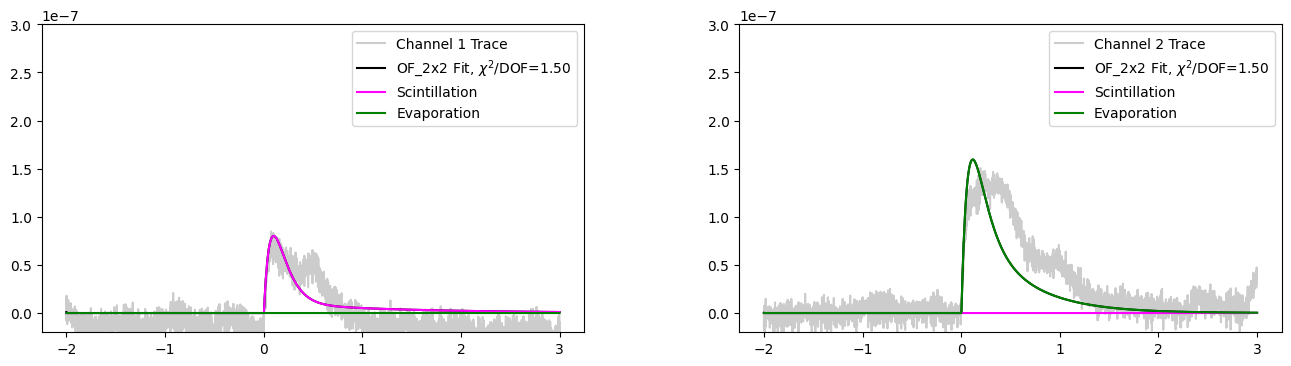

In [20]:
t=np.arange(-2,3,1/(1250))

fig = plt.figure(1,figsize=(16,4))
gs=GridSpec(4,4)
gs.update(wspace=0.8,hspace=0.5)
t=np.arange(-2,3,1/1250)# ms 
##first plot#####
xtr_subplot =fig.add_subplot(gs[0:4,0:2])

template_array_2x2 = np.asarray((CPD1_scintillation, 0*CPD2_scintillation,\
                              0*CPD1_scintillation, CPD2_scintillation))

template_11 = template_array_2x2[0]
template_21 = template_array_2x2[1]


Fit_channel_1 =  OF_2x2._of_amp_withdelay[0]*np.roll(template_11,int(OF_2x2._of_t0_withdelay*OF_2x2._fs)) + \
OF_2x2._of_amp_withdelay[1]*np.roll(template_21,int(OF_2x2._of_t0_withdelay*OF_2x2._fs)) 

plt.plot(t,signal_traces[i][0], color='k', alpha=0.2,label= "Channel 1 Trace")
plt.plot(t, Fit_channel_1 , color='k', label=(r'OF_2x2 Fit, $\chi^2/$DOF'+ f'={OF_2x2._of_chi2_withdelay/(2*6250):.2f}'))


plt.plot(t, shift(  OF_2x2._of_amp_withdelay[0]*template_11, OF_2x2._of_t0_withdelay*OF_2x2._fs ), color = 'magenta', label='Scintillation' )
plt.plot(t, shift( OF_2x2._of_amp_withdelay[1]*template_21 , OF_2x2._of_t0_withdelay*OF_2x2._fs) , \
                                                             color= 'green', label='Evaporation' )


plt.ylim(-0.2e-7,3e-7)
plt.legend()
##first plot#####
xtr_subplot =fig.add_subplot(gs[0:4,2:4])


template_12 = template_array_2x2[2]
template_22 = template_array_2x2[3]

Fit_channel_2 =  OF_2x2._of_amp_withdelay[0]*np.roll(template_12,int(OF_2x2._of_t0_withdelay*OF_2x2._fs)) +\
OF_2x2._of_amp_withdelay[1]*np.roll(template_22,int(OF_2x2._of_t0_withdelay*OF_2x2._fs)) 




plt.plot(t,signal_traces[i][1], color='k', alpha=0.2, label= "Channel 2 Trace")
plt.plot(t,Fit_channel_2, color='k', label=(r'OF_2x2 Fit, $\chi^2/$DOF'+ f'={OF_2x2._of_chi2_withdelay/(2*6250):.2f}'))

plt.plot(t, shift(  OF_2x2._of_amp_withdelay[0]*template_12, OF_2x2._of_t0_withdelay*OF_2x2._fs ), color = 'magenta', label='Scintillation' )
plt.plot(t, shift( OF_2x2._of_amp_withdelay[1]*template_22 , OF_2x2._of_t0_withdelay*OF_2x2._fs) , \
                                                             color= 'green', label='Evaporation' )

plt.ylim(-0.2e-7,3e-7)
plt.legend()